In [1]:
import json
import os
import torch
import IPython.display as ipd
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
from torch.cuda import amp
from torch.utils.tensorboard import SummaryWriter
%load_ext autoreload
%autoreload 2 
# import radtts
import os
import json
from timeit import default_timer as timer
os.chdir('/usr/src/app/radtts')
from distributed import (init_distributed, apply_gradient_allreduce,
                         reduce_tensor)

In [2]:

from radtts import RADTTS
from train import RADTTSLoss, AttentionBinarizationLoss, prepare_dataloaders, prepare_model_weights, parse_data_from_batch, compute_validation_loss
import torch
# from radtts.inference import load_vocoder
from hifigan_env import AttrDict
from data import Data
from hifigan_models import Generator
from hifigan_env import AttrDict
from hifigan_denoiser import Denoiser
from radam import RAdam

torch.cuda.set_device(0)

import numpy as np
import IPython.display as ipd


def audio_to_mel(audio):
    '''requires 22050 hz'''
    audio = torch.FloatTensor(audio)
    audio_norm = audio / (np.abs(audio).max() * 2)  # NOTE (Sam): just must be < 1
    audio_norm = audio_norm.unsqueeze(0)
    mel_template = stft.mel_spectrogram(audio_norm)
    
    return(mel_template)
    
def spectrogram_to_audio(spectrogram):
    MAX_WAV_VALUE = 32768
    hifi_gan = vocoder
    tensor_cls = torch.FloatTensor if device == "cpu" else torch.cuda.FloatTensor
    y_g_hat = hifi_gan(tensor_cls(spectrogram).to(device=device))

    audio = y_g_hat.squeeze()
    audio = audio * MAX_WAV_VALUE
    audio = audio.unsqueeze(0)

    audio_numpy = audio[0].data.cpu().numpy()
    audio_numpy = audio_numpy.astype("int16")
    return(audio_numpy)

def load_vocoder(vocoder_path, config_path, to_cuda=True):
    with open(config_path) as f:
        data_vocoder = f.read()
    config_vocoder = json.loads(data_vocoder)
    h = AttrDict(config_vocoder)
    if 'blur' in vocoder_path:
        config_vocoder['gaussian_blur']['p_blurring'] = 0.5
    else:
        if 'gaussian_blur' in config_vocoder:
            config_vocoder['gaussian_blur']['p_blurring'] = 0.0
        else:
            config_vocoder['gaussian_blur'] = {'p_blurring': 0.0}
            h['gaussian_blur'] = {'p_blurring': 0.0}

    state_dict_g = torch.load(vocoder_path, map_location='cpu')['generator']

    # load hifigan
    vocoder = Generator(h)
    vocoder.load_state_dict(state_dict_g)
    denoiser = Denoiser(vocoder)
    if to_cuda:
        vocoder.cuda()
        denoiser.cuda()
    vocoder.eval()
    denoiser.eval()

    return vocoder, denoiser

# Needs to be here cause of implicit "config" argument
def prepare_output_folders_and_logger(output_directory):
    # Get shared output_directory ready
    if not os.path.isdir(output_directory):
        os.makedirs(output_directory)
        os.chmod(output_directory, 0o775)
        print("output directory", output_directory)

    output_config_path = os.path.join(output_directory, 'config.json')
    print("saving current configuration in output dir")
    config_fp = open(output_config_path, 'w')
    json.dump(config, config_fp, indent=4)
    config_fp.close()
    output_code_path = os.path.join(output_directory, 'code.tar.gz')
    os.system('tar -czvf %s *.py' % (output_code_path))

    tboard_out_path = os.path.join(output_directory, 'logs')
    print("setting up tboard log in %s" % (tboard_out_path))
    logger = SummaryWriter(tboard_out_path)
    return logger

device = 'cuda'
config_path = "/usr/src/app/radtts/models/hifigan_22khz_config.json"
vocoder_path = "/usr/src/app/radtts/models/hifigan_libritts100360_generator0p5.pt"
vocoder, denoiser = load_vocoder(vocoder_path, config_path, to_cuda=True)


In [3]:
config_path = '/usr/src/app/radtts/configs/lj_minimal.json'
config_path = '/usr/src/app/radtts/configs/config_ljs_radtts_ljdebug.json'
with open(config_path) as f:
    config = json.load(f)
seed = 1234
# config['train_config']['learning_rate'] = 0.001
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
n_gpus = 1
train_config = config['train_config']
sigma = train_config['sigma']
model_config = config['model_config']
loss_weights = train_config['loss_weights']
learning_rate = train_config['learning_rate']
unfreeze_modules = train_config['unfreeze_modules']
weight_decay = train_config['weight_decay']
output_directory = train_config['output_directory']
use_amp = train_config['use_amp']
# batch_size = train_config['batch_size']
batch_size = 3
iters_per_checkpoint = train_config['iters_per_checkpoint']
grad_clip_val = train_config['grad_clip_val']
data_config= config['data_config']
epochs =train_config['epochs']
binarization_start_iter = train_config['binarization_start_iter']
criterion = RADTTSLoss(
    sigma,
    model_config['n_group_size'],
    model_config['dur_model_config'],
    model_config['f0_model_config'],
    model_config['energy_model_config'],
    vpred_model_config=model_config['v_model_config'],
    loss_weights=loss_weights
)
attention_kl_loss = AttentionBinarizationLoss()
model = RADTTS(**model_config).cuda()
rank = 0


Applying spectral norm to text encoder LSTM
Applying spectral norm to context encoder LSTM


/usr/src/app/radtts/common.py:391: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
/opt/conda/lib/python3.8/site-packages/torch/functional.py:1682: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/n

In [4]:
optimizer = RAdam(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay)

iteration = 0

scaler = amp.GradScaler(enabled=use_amp)

for param_group in optimizer.param_groups:
    param_group['lr'] = learning_rate

train_loader, valset, collate_fn = prepare_dataloaders(
    data_config, n_gpus, batch_size)


initializing training dataloader
Number of speakers: 1
Speaker IDS {'0': 0}
Number of files 13097
Number of files after duration filtering 13097
Dataloader initialized with no augmentations
initializing validation dataloader
Number of files 13097
Number of files after duration filtering 13097
Dataloader initialized with no augmentations


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# from uberduck_ml_dev.models.common import MelSTFT
# stft = MelSTFT()
# mel = next(enumerate(train_loader))[1]['mel'][0]
# audio = stft.griffin_lim(mel)
# ipd.Audio(audio, rate = 22050)

In [6]:
# i, batch = next(enumerate(train_loader))
# (mel, speaker_ids, text, in_lens, out_lens, attn_prior,
#  f0, voiced_mask, p_voiced, energy_avg,
#  audiopaths) = parse_data_from_batch(batch)
# # audio = vocoder(mel).float()[0]
# audio = stft.griffin_lim(mel.detach()[0])
# # ipd.Audio(audio, rate = 22050)
# ipd.Audio(audio.detach().cpu(), rate = 22050)

In [7]:
%matplotlib inline
import seaborn as sns
# sns.heatmap(mel.detach().cpu()[0])

In [8]:
logger = prepare_output_folders_and_logger(output_directory)
prepare_model_weights(model, unfreeze_modules)
model.train()

i, batch = next(enumerate(train_loader))

saving current configuration in output dir
setting up tboard log in /debug/logs
Training everything


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:


epoch_offset = 0
epochs = 1000
# ================ MAIN TRAINNIG LOOP! ===================
for epoch in range(epoch_offset, epochs):
    print("Epoch: {}".format(epoch))
#     for i, batch in enumerate(train_loader):
    
#     print(i)
    tic = timer()
    model.zero_grad()
    (mel, speaker_ids, text, in_lens, out_lens, attn_prior,
     f0, voiced_mask, p_voiced, energy_avg,
     audiopaths) = parse_data_from_batch(batch)

    binarize = iteration >= binarization_start_iter
    
    
    with amp.autocast(use_amp):
        outputs = model(
            mel, speaker_ids, text, in_lens, out_lens,
            binarize_attention=binarize, attn_prior=attn_prior,
            f0=f0, energy_avg=energy_avg,
            voiced_mask=voiced_mask, p_voiced=p_voiced)
        loss_outputs = criterion(outputs, in_lens, out_lens)

        loss = None
        for k, (v, w) in loss_outputs.items():
            if w > 0:
                loss = v * w if loss is None else loss + v * w

        w_bin = criterion.loss_weights.get('binarization_loss_weight', 1.0)
        binarization_loss = torch.zeros_like(loss)
        loss_outputs['binarization_loss'] = (binarization_loss, w_bin)

#     scaler.scale(loss).backward()
#     if grad_clip_val > 0:
#         scaler.unscale_(optimizer)
#         torch.nn.utils.clip_grad_norm_(
#             model.parameters(), grad_clip_val)
#     scaler.step(optimizer)
#     scaler.update()

#     toc = timer()
#     current_lr = optimizer.param_groups[0]['lr']
#     print_list = ["iter: {}  ({:.2f} s)  |  lr: {}".format(
#         iteration, toc-tic, current_lr)]

#     for k, (v, w) in loss_outputs.items():
#         reduced_v = reduce_tensor(v, n_gpus, 0).item()
#         loss_outputs[k] = reduced_v
#         if rank == 0:
#             print_list.append('  |  {}: {:.3f}'.format(k, v))
#             logger.add_scalar('train/'+k, reduced_v, iteration)

    if rank == 0:
        print(''.join(print_list), flush=True)

    iteration += 1

# train(n_gpus, rank, **train_config)

Epoch: 0
iter: 37  (0.59 s)  |  lr: 0.0001  |  loss_mel: -0.125  |  loss_prior_mel: 0.441  |  loss_ctc: 3.648  |  binarization_loss: 0.000
Epoch: 1
iter: 37  (0.59 s)  |  lr: 0.0001  |  loss_mel: -0.125  |  loss_prior_mel: 0.441  |  loss_ctc: 3.648  |  binarization_loss: 0.000
Epoch: 2
iter: 37  (0.59 s)  |  lr: 0.0001  |  loss_mel: -0.125  |  loss_prior_mel: 0.441  |  loss_ctc: 3.648  |  binarization_loss: 0.000
Epoch: 3
iter: 37  (0.59 s)  |  lr: 0.0001  |  loss_mel: -0.125  |  loss_prior_mel: 0.441  |  loss_ctc: 3.648  |  binarization_loss: 0.000
Epoch: 4
iter: 37  (0.59 s)  |  lr: 0.0001  |  loss_mel: -0.125  |  loss_prior_mel: 0.441  |  loss_ctc: 3.648  |  binarization_loss: 0.000
Epoch: 5
iter: 37  (0.59 s)  |  lr: 0.0001  |  loss_mel: -0.125  |  loss_prior_mel: 0.441  |  loss_ctc: 3.648  |  binarization_loss: 0.000
Epoch: 6
iter: 37  (0.59 s)  |  lr: 0.0001  |  loss_mel: -0.125  |  loss_prior_mel: 0.441  |  loss_ctc: 3.648  |  binarization_loss: 0.000
Epoch: 7
iter: 37  (0.59 s)

KeyboardInterrupt: 

In [10]:
attn_used = outputs['attn']
attn_soft = outputs['attn_soft']
durations = attn_used[0, 0].sum(0, keepdim=True)
durations = (durations + 0.5).floor().int()

model_output = model.infer(
    speaker_ids[0:1], text[0:1], 0.8,
    dur=durations,

)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


<AxesSubplot:>

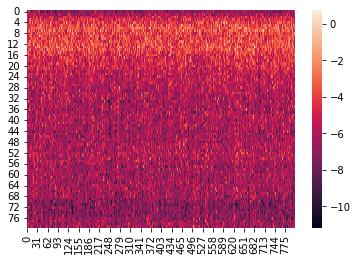

In [11]:
sns.heatmap(model_output['mel'].detach().cpu().numpy()[0])

In [12]:
i, batch = next(enumerate(train_loader))
audio = vocoder(model_output['mel'][0].detach()).cpu()[0]
# ipd.Audio(audio, rate = 22050)
ipd.Audio(audio.detach().cpu(), rate = 22050)

<AxesSubplot:>

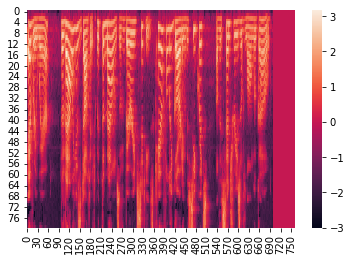

In [13]:
sns.heatmap(mel[0].detach().cpu())

In [45]:
i, batch = next(enumerate(train_loader))
audio = vocoder(mel[0].detach()).cpu()[0]
# ipd.Audio(audio, rate = 22050)
ipd.Audio(audio.detach().cpu(), rate = 22050)

In [41]:
# audio = spectrogram_to_audio(mel)


denoising_strength = 0.
# mel = outputs['mel']
audio = vocoder(mel.float()).float()[0]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
audio_denoised = denoiser(
    audio, strength=denoising_strength)[0].float()

audio = audio[0].cpu().detach().numpy()
audio_denoised = audio_denoised[0].cpu().detach().numpy()
audio_denoised = audio_denoised / np.max(np.abs(audio_denoised))


In [27]:
grad_clip_val

1.0

In [29]:


logger = prepare_output_folders_and_logger(output_directory)



prepare_model_weights(model, unfreeze_modules)
model.train()

epoch_offset = 0
epochs = 10

i, batch = next(enumerate(train_loader))
# ================ MAIN TRAINNIG LOOP! ===================
for epoch in range(epoch_offset, epochs):
    print("Epoch: {}".format(epoch))
#     for i, batch in enumerate(train_loader):
    
    print(i)
    tic = timer()
    model.zero_grad()
    (mel, speaker_ids, text, in_lens, out_lens, attn_prior,
     f0, voiced_mask, p_voiced, energy_avg,
     audiopaths) = parse_data_from_batch(batch)

    binarize = iteration >= binarization_start_iter

    with amp.autocast(use_amp):
        outputs = model(
            mel, speaker_ids, text, in_lens, out_lens,
            binarize_attention=binarize, attn_prior=attn_prior,
            f0=f0, energy_avg=energy_avg,
            voiced_mask=voiced_mask, p_voiced=p_voiced)
        loss_outputs = criterion(outputs, in_lens, out_lens)

        loss = None
        for k, (v, w) in loss_outputs.items():
            if w > 0:
                loss = v * w if loss is None else loss + v * w

        w_bin = criterion.loss_weights.get('binarization_loss_weight', 1.0)
        if binarize and iteration >= kl_loss_start_iter:
            binarization_loss = attention_kl_loss(
                outputs['attn'], outputs['attn_soft'])
            loss += binarization_loss * w_bin
        else:
            binarization_loss = torch.zeros_like(loss)
        loss_outputs['binarization_loss'] = (binarization_loss, w_bin)

    scaler.scale(loss).backward()
    if grad_clip_val > 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), grad_clip_val)
    scaler.step(optimizer)
    scaler.update()

    toc = timer()
    current_lr = optimizer.param_groups[0]['lr']
    print_list = ["iter: {}  ({:.2f} s)  |  lr: {}".format(
        iteration, toc-tic, current_lr)]

    for k, (v, w) in loss_outputs.items():
        reduced_v = reduce_tensor(v, n_gpus, 0).item()
        loss_outputs[k] = reduced_v
        if rank == 0:
            print_list.append('  |  {}: {:.3f}'.format(k, v))
            logger.add_scalar('train/'+k, reduced_v, iteration)

    if rank == 0:
        print(''.join(print_list), flush=True)

    iteration += 1

# train(n_gpus, rank, **train_config)

saving current configuration in output dir
setting up tboard log in /debug/logs
Training everything
Epoch: 0
0


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:777: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,


iter: 0  (0.84 s)  |  lr: 0.0001  |  loss_mel: 0.509  |  loss_prior_mel: 0.509  |  loss_ctc: 3.359  |  binarization_loss: 0.000


/usr/src/app/radtts/radam.py:76: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Epoch: 1
0
iter: 1  (0.26 s)  |  lr: 0.0001  |  loss_mel: 0.508  |  loss_prior_mel: 0.508  |  loss_ctc: 3.359  |  binarization_loss: 0.000
Epoch: 2
0
iter: 2  (0.27 s)  |  lr: 0.0001  |  loss_mel: 0.506  |  loss_prior_mel: 0.506  |  loss_ctc: 3.359  |  binarization_loss: 0.000
Epoch: 3
0
iter: 3  (0.27 s)  |  lr: 0.0001  |  loss_mel: 0.505  |  loss_prior_mel: 0.505  |  loss_ctc: 3.359  |  binarization_loss: 0.000
Epoch: 4
0
iter: 4  (0.27 s)  |  lr: 0.0001  |  loss_mel: 0.503  |  loss_prior_mel: 0.503  |  loss_ctc: 3.359  |  binarization_loss: 0.000
Epoch: 5
0
iter: 5  (0.29 s)  |  lr: 0.0001  |  loss_mel: 0.502  |  loss_prior_mel: 0.502  |  loss_ctc: 3.359  |  binarization_loss: 0.000
Epoch: 6
0
iter: 6  (0.29 s)  |  lr: 0.0001  |  loss_mel: 0.472  |  loss_prior_mel: 0.480  |  loss_ctc: 3.359  |  binarization_loss: 0.000
Epoch: 7
0
iter: 7  (0.29 s)  |  lr: 0.0001  |  loss_mel: 0.437  |  loss_prior_mel: 0.455  |  loss_ctc: 3.359  |  binarization_loss: 0.000
Epoch: 8
0
iter: 8  (0.29 s

In [5]:
attn_used = outputs['attn']
attn_soft = outputs['attn_soft']
durations = attn_used[0, 0].sum(0, keepdim=True)
durations = (durations + 0.5).floor().int()

In [6]:
model_output = model.infer(
    speaker_ids[0:1], text[0:1], 0.8,
    dur=durations,
#     f0=f0[0:1, :durations.sum()],
#     energy_avg=energy_avg[0:1, :durations.sum()],
#     voiced_mask=voiced_mask[0:1, :durations.sum()]
)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [7]:
#     (mel, speaker_ids, text, in_lens, out_lens, attn_prior,
#      f0, voiced_mask, p_voiced, energy_avg,
#      audiopaths) = parse_data_from_batch(batch)

In [8]:
mel = model_output['mel']

In [11]:
config_path = "/usr/src/app/radtts/models/hifigan_22khz_config.json"
vocoder_path = "/usr/src/app/radtts/models/hifigan_libritts100360_generator0p5.pt"
vocoder, denoiser = load_vocoder(vocoder_path, config_path, to_cuda=True)
denoising_strength = 0.
# mel = outputs['mel']
audio = vocoder(mel).float()[0]
audio_denoised = denoiser(
    audio, strength=denoising_strength)[0].float()

audio = audio[0].cpu().detach().numpy()
audio_denoised = audio_denoised[0].cpu().detach().numpy()
audio_denoised = audio_denoised / np.max(np.abs(audio_denoised))


In [12]:
ipd.Audio(audio_denoised, rate = 22050)

In [13]:
sns.heatmap(model_output['mel'][0].detach().cpu())

NameError: name 'sns' is not defined

In [16]:
(mel, speaker_ids, text, in_lens, out_lens, attn_prior,
 f0, voiced_mask, p_voiced, energy_avg,
 audiopaths) = parse_data_from_batch(batch)
audio = vocoder(mel).float()[0]
ipd.Audio(audio.detach().cpu(), rate= 22050)

In [66]:
torch.cuda.empty_cache()

In [53]:


audio_denoised = denoiser(
    audio, strength=denoising_strength)[0].float()

audio = audio[0].cpu().detach().numpy()
audio_denoised = audio_denoised[0].cpu().detach().numpy()
audio_denoised = audio_denoised / np.max(np.abs(audio_denoised))


In [54]:
ipd.Audio(audio_denoised, rate = 22050)

<AxesSubplot:>

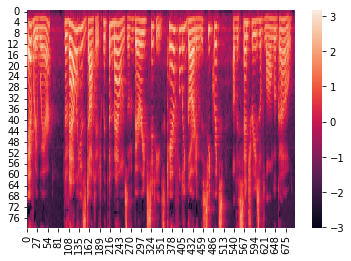

In [58]:
import seaborn as sns
%matplotlib inline
sns.heatmap(mel.cpu()[0])

In [24]:
# ignore_keys = ['training_files', 'validation_files']
# trainset = Data(
#     data_config['training_files'],
#     **dict((k, v) for k, v in data_config.items() if k not in ignore_keys))


# import numpy as np
# sigma = .8
# sigma_tkndur = 0.666
# sigma_f0 = 1.0
# sigma_energy = 1.0
# f0_mean = 0.0
# f0_std = 0.0
# energy_mean = 0.0
# energy_std = 0.0
# token_dur_scaling = 1.
# n_takes = 1
# use_amp = True
# plot = True
# seed = 1234
# text = 'This is a test of the rad inference.'
# text = trainset.get_text(text).cuda()[None]

# speaker = '0'
# speaker_text = '0'

# speaker_attributes = None
# speaker_id_text, speaker_id_attributes = speaker_id, speaker_id
# if speaker_text is not None:
#     speaker_id_text = trainset.get_speaker_id(speaker_text).cuda()
# speaker_id = trainset.get_speaker_id(speaker).cuda()
# # outputs = model.infer(speaker_id, text, sigma, sigma_tkndur, sigma_f0,
# #                         sigma_energy, token_dur_scaling, token_duration_max=100,
# #                         speaker_id_text=speaker_id_text,
# #                         speaker_id_attributes=speaker_id_attributes,
# #                         f0_mean=f0_mean, f0_std=f0_std, energy_mean=energy_mean,
# #                         energy_std=energy_std)

In [25]:
# outputs = model(
#     mel, speaker_ids, text, in_lens, out_lens,
#     binarize_attention=binarize, attn_prior=attn_prior,
#     f0=f0, energy_avg=energy_avg,
#     voiced_mask=voiced_mask, p_voiced=p_voiced)